In [1]:
import numpy as np
import os
#from scipy.misc import imread, imresize
from skimage.io import imread
from cv2 import resize
import datetime
import os
import matplotlib.pyplot as plt

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
#train_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/train.csv').readlines())
train_doc = np.random.permutation(open('C:\\Users\\chait\\Gesture_recognition_project\\Project_data\\train.csv').readlines())
#val_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/val.csv').readlines())
val_doc = np.random.permutation(open('C:\\Users\\chait\\Gesture_recognition_project\\Project_data\\val.csv').readlines())
batch_size = 20
frames_per_vedio = 30
x = 160 # x-axis of the image
y = 160 #y-axis of the image

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

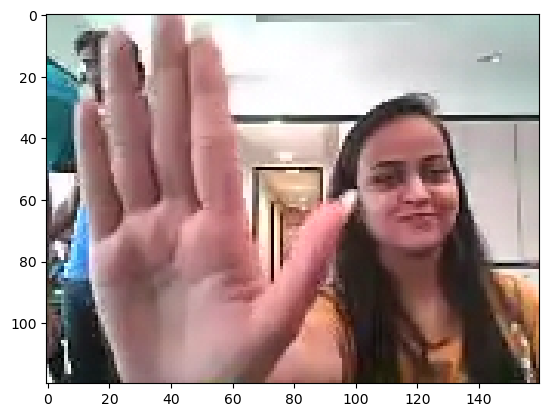

In [56]:
t = np.random.permutation(train_doc)
train = "C:\\Users\chait\\Gesture_recognition_project\\Project_data\\train"
imgs = os.listdir(train+'/'+ train_doc[10].strip().split(';')[0])
#k = train+'/'+ t[10].strip().split(';')[0]+'/'+imgs[24]
image = imread(train+'/'+ train_doc[10].strip().split(';')[0]+'/'+imgs[24])
                    
plt.imshow(image)

In [6]:
def crop_resize_image(image):
    height = image.shape[0]
    width = image.shape[1] 
    #image = image[int(0.1*height):int(0.9*height), int(0.1*width):int(0.9*width)]
    image = resize(image,(x,y))
    image = image/255
    return image

In [7]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    numbers = list(range(frames_per_vedio))
    np.random.shuffle(numbers)
    img_idx = sorted(numbers[:frames_per_vedio])  #create a list of image numbers you want to use for a particular video
    #img_dx = list(range(frames_per_vedio))
    
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size  # calculate the number of batches
        num_remainder_batches = len(folder_list)%batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,frames_per_vedio,x,y,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image = crop_resize_image(image)
                    batch_data[folder,idx,:,:,0] = image[:,:,0]#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if num_remainder_batches !=0 :
            batch_data = np.zeros((num_remainder_batches,frames_per_vedio,x,y,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((num_remainder_batches,5))
            for folder in range(num_remainder_batches): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image = crop_resize_image(image)
                    batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [57]:
curr_dt_time = datetime.datetime.now()
train_path = "\\Project_data\\train"
val_path = "\\Project_data\\val"
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 5 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 5


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l2
from keras.optimizers import Adam
from keras import optimizers

#### Model-1: 
- Optimizer : Adam
- Learning_rate : 0.001
- Epochs : 25
- Frames_per_vedio : 20
- batch_size : 20

In [10]:

learning_rate = 0.001
num_epochs = 4
gestures=5
frames_per_vedio = 30
batch_size = 20

#write your model here
#Layer-1
model = Sequential()
model.add(Conv3D(8,(3,3,3),padding='same', input_shape = (frames_per_vedio, x, y, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#model.add(MaxPooling3D(pool_size = (2,2,2)))

model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))




#Layer-3
model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))



model.add(Dense(gestures, activation = 'softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [11]:
optimiser =  Adam(learning_rate = learning_rate)#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 160, 160, 8)   656       
                                                                 
 batch_normalization (Batch  (None, 30, 160, 160, 8)   32        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 30, 160, 160, 8)   0         
                                                                 
 max_pooling3d (MaxPooling3  (None, 15, 80, 80, 8)     0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 80, 80, 32)    6944      
                                                                 
 batch_normalization_1 (Bat  (None, 15, 80, 80, 32)    1

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [12]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [13]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 2, verbose = 1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [14]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

### Ablation run

In [56]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  C:\Users\chait\Gesture_recognition_project\Project_data\train ; batch size = 20
Epoch 1/4
34/34 [==============================] - ETA: 0s - loss: 1.4077 - categorical_accuracy: 0.4299Source path =  C:\Users\chait\Gesture_recognition_project\Project_data\val ; batch size = 20

Epoch 1: saving model to model_init_2024-01-0119_17_14.502054\model-00001-1.40772-0.42986-1.76576-0.26000.h5
34/34 [==============================] - 254s 7s/step - loss: 1.4077 - categorical_accuracy: 0.4299 - val_loss: 1.7658 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/4
34/34 [==============================] - ETA: 0s - loss: 0.8679 - categorical_accuracy: 0.6923
Epoch 2: saving model to model_init_2024-01-0119_17_14.502054\model-00002-0.86786-0.69231-2.54987-0.24000.h5
34/34 [==============================] - 235s 7s/step - loss: 0.8679 - categorical_accuracy: 0.6923 - val_loss: 2.5499 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/4
34/34 [==============================] -

#### Train_ accuracy: 86, Validation_ accuracy: 24. 
Here we can clearly see that the model has overfit as the number of epochs is very less.

### Experiment 1 Changing the number of filters
#### Model-1: 
- Optimizer : Adam
- Learning_rate : 0.001
- Epochs : 2
- Frames_per_vedio : 30
- batch_size : 20
- image_size : 160 x 160

In [58]:
gestures=5
learning_rate = 0.001
num_epochs = 2
gestures=5
frames_per_vedio = 30
batch_size = 30
x = 160
y = 160


#write your model here
#Layer-1
model1 = Sequential()
model1.add(Conv3D(8,(3,3,3), activation = 'relu', input_shape = (frames_per_vedio, x, y, 3)))
model1.add(BatchNormalization())
model1.add(MaxPooling3D(pool_size = (2,2,2)))

#Layer-2
model1.add(Conv3D(16,(3,3,3), activation = 'relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling3D(pool_size = (2,2,2)))

model1.add(Conv3D(64,(3,3,3), activation = 'relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling3D(pool_size = (2,2,2)))


#Layer-3
model1.add(Flatten())
model1.add(Dense(32, activation = 'relu'))
model1.add(Dropout(0.5))


#output
model1.add(Dense(gestures, activation = 'softmax'))

optimiser =  optimizers.SGD(learning_rate = 0.01, weight_decay  = 1e-5, momentum = 0.7, nesterov = True)#write your optimizer
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model1.summary())

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_60 (Conv3D)          (None, 28, 158, 158, 8)   656       
                                                                 
 batch_normalization_89 (Ba  (None, 28, 158, 158, 8)   32        
 tchNormalization)                                               
                                                                 
 max_pooling3d_60 (MaxPooli  (None, 14, 79, 79, 8)     0         
 ng3D)                                                           
                                                                 
 conv3d_61 (Conv3D)          (None, 12, 77, 77, 16)    3472      
                                                                 
 batch_normalization_90 (Ba  (None, 12, 77, 77, 16)    64        
 tchNormalization)                                               
                                                     

In [16]:
history = model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  C:\Users\chait\Gesture_recognition_project\Project_data\train ; batch size = 20
Epoch 1/2


34/34 [==============================] - ETA: 0s - loss: 2.8879 - categorical_accuracy: 0.2157Source path =  C:\Users\chait\Gesture_recognition_project\Project_data\val ; batch size = 20

Epoch 1: saving model to model_init_2024-01-0210_29_35.492045\model-00001-2.88791-0.21569-2.82720-0.20000.h5
34/34 [==============================] - 190s 5s/step - loss: 2.8879 - categorical_accuracy: 0.2157 - val_loss: 2.8272 - val_categorical_accuracy: 0.2000 - lr: 0.0100
Epoch 2/2


C:\Users\chait\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - ETA: 0s - loss: 1.7339 - categorical_accuracy: 0.2097
Epoch 2: saving model to model_init_2024-01-0210_29_35.492045\model-00002-1.73385-0.20965-1.99088-0.21000.h5
34/34 [==============================] - 159s 5s/step - loss: 1.7339 - categorical_accuracy: 0.2097 - val_loss: 1.9909 - val_categorical_accuracy: 0.2100 - lr: 0.0100


#### The model seems to be learning something, now running the same model for 20 epochs. 

In [61]:
num_epochs = 40
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history1 = model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/40
34/34 [==============================] - ETA: 0s - loss: 1.4859 - categorical_accuracy: 0.2881
Epoch 1: saving model to model_init_2024-01-0210_29_35.492045\model-00001-1.48593-0.28808-1.69551-0.28000.h5
34/34 [==============================] - 133s 4s/step - loss: 1.4859 - categorical_accuracy: 0.2881 - val_loss: 1.6955 - val_categorical_accuracy: 0.2800 - lr: 1.0000e-06
Epoch 2/40
34/34 [==============================] - ETA: 0s - loss: 1.4787 - categorical_accuracy: 0.2911
Epoch 2: saving model to model_init_2024-01-0210_29_35.492045\model-00002-1.47870-0.29110-1.62409-0.28000.h5
34/34 [==============================] - 125s 4s/step - loss: 1.4787 - categorical_accuracy: 0.2911 - val_loss: 1.6241 - val_categorical_accuracy: 0.2800 - lr: 1.0000e-06
Epoch 3/40
34/34 [==============================] - ETA: 0s - loss: 1.4770 - categorical_accuracy: 0.2986
Epoch 3: saving model to model_init_2024-01-0210_29_35.492045\model-00003-1.47705-0.29864-1.74628-0.31000.h5
34/34 [======

Epoch 21/40
34/34 [==============================] - ETA: 0s - loss: 1.5027 - categorical_accuracy: 0.2866
Epoch 21: saving model to model_init_2024-01-0210_29_35.492045\model-00021-1.50271-0.28658-1.73800-0.33000.h5

Epoch 21: ReduceLROnPlateau reducing learning rate to 9.999999146890344e-15.
34/34 [==============================] - 122s 4s/step - loss: 1.5027 - categorical_accuracy: 0.2866 - val_loss: 1.7380 - val_categorical_accuracy: 0.3300 - lr: 1.0000e-13
Epoch 22/40
34/34 [==============================] - ETA: 0s - loss: 1.4915 - categorical_accuracy: 0.2805
Epoch 22: saving model to model_init_2024-01-0210_29_35.492045\model-00022-1.49155-0.28054-1.65579-0.35000.h5
34/34 [==============================] - 124s 4s/step - loss: 1.4915 - categorical_accuracy: 0.2805 - val_loss: 1.6558 - val_categorical_accuracy: 0.3500 - lr: 1.0000e-14
Epoch 23/40
34/34 [==============================] - ETA: 0s - loss: 1.4964 - categorical_accuracy: 0.2836
Epoch 23: saving model to model_init_20


Epoch 40: ReduceLROnPlateau reducing learning rate to 9.999999682655227e-24.
34/34 [==============================] - 125s 4s/step - loss: 1.4970 - categorical_accuracy: 0.2896 - val_loss: 1.6213 - val_categorical_accuracy: 0.3100 - lr: 1.0000e-22


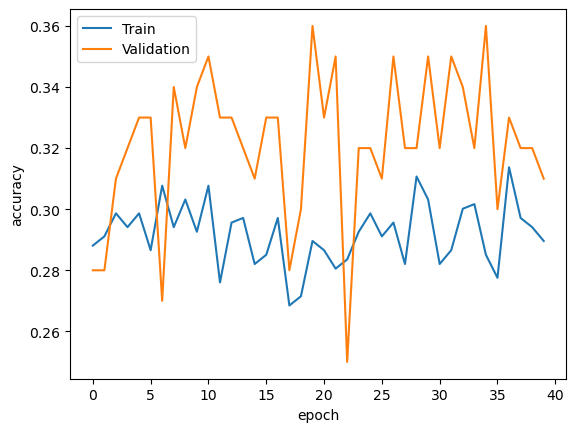

In [62]:
plt.plot(history1.history['categorical_accuracy'])
plt.plot(history1.history['val_categorical_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Validation'])

#### Both the accuracies are low and both are close to each other, this implies that the model is learning something but not the intended features. So lets change the parameters and try.

### Experiment 2 
#### As the above model with filters ([8,16,64]) has not proved to be successful, now going back to the model with ([8,32,64]) and executing it for 40 epochs.
#### Model-2: 
- Optimizer : SGD
- Learning_rate : 0.001
- Epochs : 40
- Frames_per_vedio : 30
- batch_size : 300
- image_size : 160 x 160

In [22]:
gestures=5
learning_rate = 0.001
num_epochs = 40
gestures=5
frames_per_vedio = 30
batch_size = 30
x = 160
y = 160




#write your model here
#Layer-1
model = Sequential()
model.add(Conv3D(8,(3,3,3),padding='same', input_shape = (frames_per_vedio, x, y, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#model.add(MaxPooling3D(pool_size = (2,2,2)))

model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))




#Layer-3
model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))



model.add(Dense(gestures, activation = 'softmax'))


optimiser =  optimizers.SGD(learning_rate = 0.01, weight_decay  = 1e-5, momentum = 0.7, nesterov = True)#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_15 (Conv3D)          (None, 30, 160, 160, 8)   656       
                                                                 
 batch_normalization_19 (Ba  (None, 30, 160, 160, 8)   32        
 tchNormalization)                                               
                                                                 
 activation_12 (Activation)  (None, 30, 160, 160, 8)   0         
                                                                 
 max_pooling3d_15 (MaxPooli  (None, 15, 80, 80, 8)     0         
 ng3D)                                                           
                                                                 
 conv3d_16 (Conv3D)          (None, 15, 80, 80, 32)    6944      
                                                                 
 batch_normalization_20 (Ba  (None, 15, 80, 80, 32)   

In [23]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/40
34/34 [==============================] - ETA: 0s - loss: 1.4705 - categorical_accuracy: 0.3876
Epoch 1: saving model to model_init_2024-01-0210_29_35.492045\model-00001-1.47052-0.38763-31.71261-0.18000.h5
34/34 [==============================] - 254s 7s/step - loss: 1.4705 - categorical_accuracy: 0.3876 - val_loss: 31.7126 - val_categorical_accuracy: 0.1800 - lr: 0.0100
Epoch 2/40
34/34 [==============================] - ETA: 0s - loss: 1.2009 - categorical_accuracy: 0.5189
Epoch 2: saving model to model_init_2024-01-0210_29_35.492045\model-00002-1.20091-0.51885-5.81548-0.18000.h5
34/34 [==============================] - 247s 7s/step - loss: 1.2009 - categorical_accuracy: 0.5189 - val_loss: 5.8155 - val_categorical_accuracy: 0.1800 - lr: 0.0100
Epoch 3/40
34/34 [==============================] - ETA: 0s - loss: 1.0212 - categorical_accuracy: 0.5807
Epoch 3: saving model to model_init_2024-01-0210_29_35.492045\model-00003-1.02121-0.58069-1.54834-0.40000.h5
34/34 [============

34/34 [==============================] - 245s 7s/step - loss: 0.4676 - categorical_accuracy: 0.8703 - val_loss: 0.5477 - val_categorical_accuracy: 0.8200 - lr: 1.0000e-06
Epoch 22/40
34/34 [==============================] - ETA: 0s - loss: 0.4774 - categorical_accuracy: 0.8416
Epoch 22: saving model to model_init_2024-01-0210_29_35.492045\model-00022-0.47741-0.84163-0.52738-0.82000.h5
34/34 [==============================] - 254s 8s/step - loss: 0.4774 - categorical_accuracy: 0.8416 - val_loss: 0.5274 - val_categorical_accuracy: 0.8200 - lr: 1.0000e-06
Epoch 23/40
34/34 [==============================] - ETA: 0s - loss: 0.4160 - categorical_accuracy: 0.8793
Epoch 23: saving model to model_init_2024-01-0210_29_35.492045\model-00023-0.41602-0.87934-0.66244-0.75000.h5
34/34 [==============================] - 271s 8s/step - loss: 0.4160 - categorical_accuracy: 0.8793 - val_loss: 0.6624 - val_categorical_accuracy: 0.7500 - lr: 1.0000e-06
Epoch 24/40
34/34 [==============================] - 

### Epoch 39 shows train accuracy of 85 and validation accuracy 83. So far this is the best result.

#### plotting the training and validation accuracies

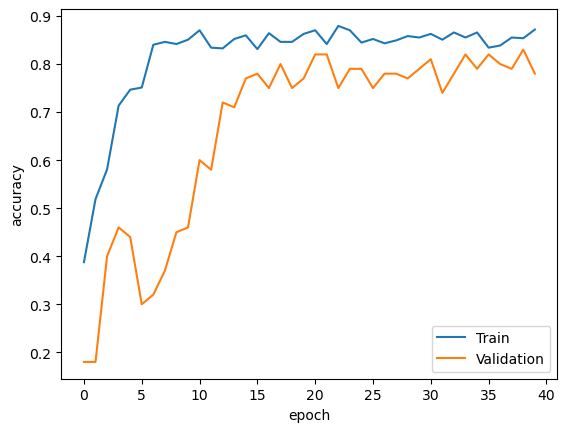

In [26]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Validation'])

### Experiment - 3
As the above CNN network produced considerably good results lets use the same, but change the image size from 160 x 160 to 140 x 140.
#### Model-2: 
- Optimizer : SGD
- Learning_rate : 0.001
- Epochs : 40
- Frames_per_vedio : 30
- batch_size : 300
- image_size : 140 x 140

In [28]:
gestures=5
learning_rate = 0.001
num_epochs = 4
gestures=5
frames_per_vedio = 30
batch_size = 30
x = 140
y = 140




#write your model here
#Layer-1
model3 = Sequential()
model3.add(Conv3D(8,(3,3,3),padding='same', input_shape = (frames_per_vedio, x, y, 3)))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

#model.add(MaxPooling3D(pool_size = (2,2,2)))

model3.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model3.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))




#Layer-3
model3.add(Flatten())
model3.add(Dense(32, activation = 'relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))



model3.add(Dense(gestures, activation = 'softmax'))


optimiser =  optimizers.SGD(learning_rate = 0.01, weight_decay  = 1e-5, momentum = 0.7, nesterov = True)#write your optimizer
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_21 (Conv3D)          (None, 30, 140, 140, 8)   656       
                                                                 
 batch_normalization_27 (Ba  (None, 30, 140, 140, 8)   32        
 tchNormalization)                                               
                                                                 
 activation_18 (Activation)  (None, 30, 140, 140, 8)   0         
                                                                 
 max_pooling3d_21 (MaxPooli  (None, 15, 70, 70, 8)     0         
 ng3D)                                                           
                                                                 
 conv3d_22 (Conv3D)          (None, 15, 70, 70, 32)    6944      
                                                                 
 batch_normalization_28 (Ba  (None, 15, 70, 70, 32)   

#### Executing for 4 epochs

In [29]:
history = model3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/4
34/34 [==============================] - ETA: 0s - loss: 1.3904 - categorical_accuracy: 0.4344
Epoch 1: saving model to model_init_2024-01-0210_29_35.492045\model-00001-1.39044-0.43439-2.35173-0.19000.h5
34/34 [==============================] - 207s 6s/step - loss: 1.3904 - categorical_accuracy: 0.4344 - val_loss: 2.3517 - val_categorical_accuracy: 0.1900 - lr: 0.0100
Epoch 2/4
34/34 [==============================] - ETA: 0s - loss: 0.8952 - categorical_accuracy: 0.6787
Epoch 2: saving model to model_init_2024-01-0210_29_35.492045\model-00002-0.89521-0.67873-3.24566-0.15000.h5
34/34 [==============================] - 199s 6s/step - loss: 0.8952 - categorical_accuracy: 0.6787 - val_loss: 3.2457 - val_categorical_accuracy: 0.1500 - lr: 0.0100
Epoch 3/4
34/34 [==============================] - ETA: 0s - loss: 0.7655 - categorical_accuracy: 0.7210
Epoch 3: saving model to model_init_2024-01-0210_29_35.492045\model-00003-0.76548-0.72097-4.01934-0.17000.h5

Epoch 3: ReduceLROnPlat

#### We can see the model has overfit, so lets increase the number of epochs and see.

### Experiment - 4 
#### Model-2: 
- Optimizer : SGD
- Learning_rate : 0.001
- Epochs : 20
- Frames_per_vedio : 30
- batch_size : 35
- image_size : 140 x 140

In [30]:
gestures=5
learning_rate = 0.001
num_epochs = 20
gestures=5
frames_per_vedio = 30
batch_size = 35
x = 140
y = 140




#write your model here
#Layer-1
model4 = Sequential()
model4.add(Conv3D(8,(3,3,3),padding='same', input_shape = (frames_per_vedio, x, y, 3)))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(2, 2, 2)))

#model.add(MaxPooling3D(pool_size = (2,2,2)))

model4.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(2, 2, 2)))

model4.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(2, 2, 2)))




#Layer-3
model4.add(Flatten())
model4.add(Dense(32, activation = 'relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.5))



model4.add(Dense(gestures, activation = 'softmax'))


optimiser =  optimizers.SGD(learning_rate = 0.01, weight_decay  = 1e-5, momentum = 0.7, nesterov = True)#write your optimizer
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model4.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 30, 140, 140, 8)   656       
                                                                 
 batch_normalization_31 (Ba  (None, 30, 140, 140, 8)   32        
 tchNormalization)                                               
                                                                 
 activation_21 (Activation)  (None, 30, 140, 140, 8)   0         
                                                                 
 max_pooling3d_24 (MaxPooli  (None, 15, 70, 70, 8)     0         
 ng3D)                                                           
                                                                 
 conv3d_25 (Conv3D)          (None, 15, 70, 70, 32)    6944      
                                                                 
 batch_normalization_32 (Ba  (None, 15, 70, 70, 32)   

In [31]:
history = model4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.3292 - categorical_accuracy: 0.4796
Epoch 1: saving model to model_init_2024-01-0210_29_35.492045\model-00001-1.32921-0.47964-1.67759-0.18000.h5
34/34 [==============================] - 207s 6s/step - loss: 1.3292 - categorical_accuracy: 0.4796 - val_loss: 1.6776 - val_categorical_accuracy: 0.1800 - lr: 0.0100
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.9047 - categorical_accuracy: 0.6682
Epoch 2: saving model to model_init_2024-01-0210_29_35.492045\model-00002-0.90469-0.66817-1.91746-0.23000.h5
34/34 [==============================] - 198s 6s/step - loss: 0.9047 - categorical_accuracy: 0.6682 - val_loss: 1.9175 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.7511 - categorical_accuracy: 0.7300
Epoch 3: saving model to model_init_2024-01-0210_29_35.492045\model-00003-0.75114-0.73002-1.74177-0.24000.h5

Epoch 3: ReduceLROnP

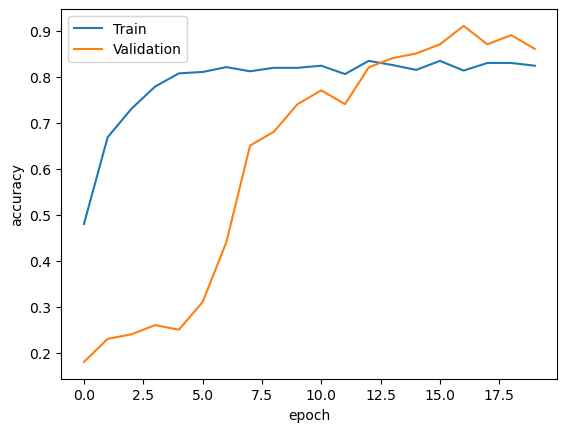

In [32]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Validation'])

### This is also a decent performance, at 13th epoch we see that almost both the accuracies are same at 83%

### Experiment - 5

#### Now lets see what happens if we increase the depth of the network. Keeping the sizeof the image same, 140 x 140. 
Replacing the dense layer of 32 nuerons with 64 and also adding one more layer of 128.
#### Model-5: 
- Optimizer : SGD
- Learning_rate : 0.001
- Epochs : 4
- Frames_per_vedio : 30
- batch_size : 35
- image_size : 140 x 140

In [34]:
gestures=5
learning_rate = 0.001
num_epochs = 4
gestures=5
frames_per_vedio = 30
batch_size = 35
x = 140
y = 140




#write your model here
#Layer-1
model5 = Sequential()
model5.add(Conv3D(8,(3,3,3),padding='same', input_shape = (frames_per_vedio, x, y, 3)))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling3D(pool_size=(2, 2, 2)))

#model.add(MaxPooling3D(pool_size = (2,2,2)))

model5.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling3D(pool_size=(2, 2, 2)))

model5.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling3D(pool_size=(2, 2, 2)))


model5.add(Flatten())
model5.add(Dense(128, activation = 'relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.5))

model5.add(Dense(64, activation = 'relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.5))



model5.add(Dense(gestures, activation = 'softmax'))


optimiser =  optimizers.SGD(learning_rate = 0.01, weight_decay  = 1e-5, momentum = 0.7, nesterov = True)#write your optimizer
model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model5.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_30 (Conv3D)          (None, 30, 140, 140, 8)   656       
                                                                 
 batch_normalization_39 (Ba  (None, 30, 140, 140, 8)   32        
 tchNormalization)                                               
                                                                 
 activation_27 (Activation)  (None, 30, 140, 140, 8)   0         
                                                                 
 max_pooling3d_30 (MaxPooli  (None, 15, 70, 70, 8)     0         
 ng3D)                                                           
                                                                 
 conv3d_31 (Conv3D)          (None, 15, 70, 70, 32)    6944      
                                                                 
 batch_normalization_40 (Ba  (None, 15, 70, 70, 32)  

In [35]:
 history = model5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/4
34/34 [==============================] - ETA: 0s - loss: 1.7662 - categorical_accuracy: 0.3680
Epoch 1: saving model to model_init_2024-01-0210_29_35.492045\model-00001-1.76618-0.36802-4.19703-0.23000.h5
34/34 [==============================] - 232s 7s/step - loss: 1.7662 - categorical_accuracy: 0.3680 - val_loss: 4.1970 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 2/4
34/34 [==============================] - ETA: 0s - loss: 1.3524 - categorical_accuracy: 0.4585
Epoch 2: saving model to model_init_2024-01-0210_29_35.492045\model-00002-1.35245-0.45852-18.87854-0.24000.h5
34/34 [==============================] - 208s 6s/step - loss: 1.3524 - categorical_accuracy: 0.4585 - val_loss: 18.8785 - val_categorical_accuracy: 0.2400 - lr: 0.0100
Epoch 3/4
34/34 [==============================] - ETA: 0s - loss: 1.1322 - categorical_accuracy: 0.5505
Epoch 3: saving model to model_init_2024-01-0210_29_35.492045\model-00003-1.13223-0.55053-20.71910-0.22000.h5

Epoch 3: ReduceLROnP

In [36]:
gestures=5
learning_rate = 0.001
num_epochs = 4
gestures=5
frames_per_vedio = 30
batch_size = 35
x = 140
y = 140




#write your model here
#Layer-1
model5 = Sequential()
model5.add(Conv3D(8,(3,3,3),padding='same', input_shape = (frames_per_vedio, x, y, 3)))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling3D(pool_size=(2, 2, 2)))

#model.add(MaxPooling3D(pool_size = (2,2,2)))

model5.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling3D(pool_size=(2, 2, 2)))

model5.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling3D(pool_size=(2, 2, 2)))


model5.add(Flatten())
model5.add(Dense(256, activation = 'relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.5))

model5.add(Dense(128, activation = 'relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.5))



model5.add(Dense(gestures, activation = 'softmax'))


optimiser =  optimizers.SGD(learning_rate = 0.01, weight_decay  = 1e-5, momentum = 0.7, nesterov = True)#write your optimizer
model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model5.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_33 (Conv3D)          (None, 30, 140, 140, 8)   656       
                                                                 
 batch_normalization_44 (Ba  (None, 30, 140, 140, 8)   32        
 tchNormalization)                                               
                                                                 
 activation_30 (Activation)  (None, 30, 140, 140, 8)   0         
                                                                 
 max_pooling3d_33 (MaxPooli  (None, 15, 70, 70, 8)     0         
 ng3D)                                                           
                                                                 
 conv3d_34 (Conv3D)          (None, 15, 70, 70, 32)    6944      
                                                                 
 batch_normalization_45 (Ba  (None, 15, 70, 70, 32)  

In [37]:
 history = model5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/4
34/34 [==============================] - ETA: 0s - loss: 1.9049 - categorical_accuracy: 0.3499
Epoch 1: saving model to model_init_2024-01-0210_29_35.492045\model-00001-1.90485-0.34992-7.31986-0.24000.h5
34/34 [==============================] - 222s 6s/step - loss: 1.9049 - categorical_accuracy: 0.3499 - val_loss: 7.3199 - val_categorical_accuracy: 0.2400 - lr: 0.0100
Epoch 2/4
34/34 [==============================] - ETA: 0s - loss: 1.3390 - categorical_accuracy: 0.5324
Epoch 2: saving model to model_init_2024-01-0210_29_35.492045\model-00002-1.33904-0.53243-6.17712-0.17000.h5
34/34 [==============================] - 211s 6s/step - loss: 1.3390 - categorical_accuracy: 0.5324 - val_loss: 6.1771 - val_categorical_accuracy: 0.1700 - lr: 0.0100
Epoch 3/4
34/34 [==============================] - ETA: 0s - loss: 1.0227 - categorical_accuracy: 0.5837
Epoch 3: saving model to model_init_2024-01-0210_29_35.492045\model-00003-1.02271-0.58371-1.73680-0.46000.h5
34/34 [=================

In [42]:
gestures=5
learning_rate = 0.001
num_epochs = 4
gestures=5
frames_per_vedio = 30
batch_size = 35
x = 140
y = 140




#write your model here
#Layer-1
model5 = Sequential()
model5.add(Conv3D(8,(3,3,3),padding='same', input_shape = (frames_per_vedio, x, y, 3)))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling3D(pool_size=(2, 2, 2)))

#model.add(MaxPooling3D(pool_size = (2,2,2)))

model5.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling3D(pool_size=(2, 2, 2)))

model5.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling3D(pool_size=(2, 2, 2)))


model5.add(Flatten())
model5.add(Dense(128, activation = 'relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.5))

model5.add(Dense(128, activation = 'relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.5))



model5.add(Dense(gestures, activation = 'softmax'))


optimiser =  optimizers.SGD(learning_rate = 0.001, weight_decay  = 1e-5, momentum = 0.7, nesterov = True)#write your optimizer
model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model5.summary())

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_45 (Conv3D)          (None, 30, 140, 140, 8)   656       
                                                                 
 batch_normalization_64 (Ba  (None, 30, 140, 140, 8)   32        
 tchNormalization)                                               
                                                                 
 activation_42 (Activation)  (None, 30, 140, 140, 8)   0         
                                                                 
 max_pooling3d_45 (MaxPooli  (None, 15, 70, 70, 8)     0         
 ng3D)                                                           
                                                                 
 conv3d_46 (Conv3D)          (None, 15, 70, 70, 32)    6944      
                                                                 
 batch_normalization_65 (Ba  (None, 15, 70, 70, 32)  

In [39]:
 history = model5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/4
34/34 [==============================] - ETA: 0s - loss: 1.8610 - categorical_accuracy: 0.3876
Epoch 1: saving model to model_init_2024-01-0210_29_35.492045\model-00001-1.86101-0.38763-4.89924-0.17000.h5
34/34 [==============================] - 201s 6s/step - loss: 1.8610 - categorical_accuracy: 0.3876 - val_loss: 4.8992 - val_categorical_accuracy: 0.1700 - lr: 0.0100
Epoch 2/4
34/34 [==============================] - ETA: 0s - loss: 1.3168 - categorical_accuracy: 0.4947
Epoch 2: saving model to model_init_2024-01-0210_29_35.492045\model-00002-1.31677-0.49472-1.51067-0.39000.h5
34/34 [==============================] - 193s 6s/step - loss: 1.3168 - categorical_accuracy: 0.4947 - val_loss: 1.5107 - val_categorical_accuracy: 0.3900 - lr: 0.0100
Epoch 3/4
34/34 [==============================] - ETA: 0s - loss: 0.9685 - categorical_accuracy: 0.6335
Epoch 3: saving model to model_init_2024-01-0210_29_35.492045\model-00003-0.96848-0.63348-1.33894-0.48000.h5
34/34 [=================

### The model seems to be performing reasonably good, so increasing the epochs and also reducing the strating learning rate to 0.001
#### Model-6: 
- Optimizer : SGD
- Learning_rate : 0.001
- Epochs : 25
- Frames_per_vedio : 30
- batch_size : 35
- image_size : 140 x 140

In [45]:
gestures=5
learning_rate = 0.001
num_epochs = 25
gestures=5
frames_per_vedio = 30
batch_size = 35
x = 140
y = 140




#write your model here
#Layer-1
model6 = Sequential()
model6.add(Conv3D(8,(3,3,3),padding='same', input_shape = (frames_per_vedio, x, y, 3)))
model6.add(BatchNormalization())
model6.add(Activation('relu'))
model6.add(MaxPooling3D(pool_size=(2, 2, 2)))

#model.add(MaxPooling3D(pool_size = (2,2,2)))

model6.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
model6.add(BatchNormalization())
model6.add(Activation('relu'))
model6.add(MaxPooling3D(pool_size=(2, 2, 2)))

model6.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model6.add(BatchNormalization())
model6.add(Activation('relu'))
model6.add(MaxPooling3D(pool_size=(2, 2, 2)))


model6.add(Flatten())
model6.add(Dense(128, activation = 'relu'))
model6.add(BatchNormalization())
model6.add(Dropout(0.5))

model6.add(Dense(128, activation = 'relu'))
model6.add(BatchNormalization())
model6.add(Dropout(0.5))



model6.add(Dense(gestures, activation = 'softmax'))


optimiser =  optimizers.SGD(learning_rate = 0.001, weight_decay  = 1e-5, momentum = 0.7, nesterov = True)#write your optimizer
model6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model6.summary())

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_51 (Conv3D)          (None, 30, 140, 140, 8)   656       
                                                                 
 batch_normalization_74 (Ba  (None, 30, 140, 140, 8)   32        
 tchNormalization)                                               
                                                                 
 activation_48 (Activation)  (None, 30, 140, 140, 8)   0         
                                                                 
 max_pooling3d_51 (MaxPooli  (None, 15, 70, 70, 8)     0         
 ng3D)                                                           
                                                                 
 conv3d_52 (Conv3D)          (None, 15, 70, 70, 32)    6944      
                                                                 
 batch_normalization_75 (Ba  (None, 15, 70, 70, 32)  

In [46]:
 history6 = model6.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.8227 - categorical_accuracy: 0.4223
Epoch 1: saving model to model_init_2024-01-0210_29_35.492045\model-00001-1.82266-0.42232-1.74950-0.21000.h5
34/34 [==============================] - 216s 6s/step - loss: 1.8227 - categorical_accuracy: 0.4223 - val_loss: 1.7495 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.5792 - categorical_accuracy: 0.4540
Epoch 2: saving model to model_init_2024-01-0210_29_35.492045\model-00002-1.57919-0.45400-2.28869-0.29000.h5
34/34 [==============================] - 189s 6s/step - loss: 1.5792 - categorical_accuracy: 0.4540 - val_loss: 2.2887 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.1716 - categorical_accuracy: 0.5807
Epoch 3: saving model to model_init_2024-01-0210_29_35.492045\model-00003-1.17157-0.58069-3.50811-0.19000.h5

Epoch 3: ReduceLROnP

34/34 [==============================] - ETA: 0s - loss: 1.0055 - categorical_accuracy: 0.6456
Epoch 21: saving model to model_init_2024-01-0210_29_35.492045\model-00021-1.00554-0.64555-0.72895-0.77000.h5
34/34 [==============================] - 185s 5s/step - loss: 1.0055 - categorical_accuracy: 0.6456 - val_loss: 0.7290 - val_categorical_accuracy: 0.7700 - lr: 1.0000e-08
Epoch 22/25
34/34 [==============================] - ETA: 0s - loss: 0.9708 - categorical_accuracy: 0.6305
Epoch 22: saving model to model_init_2024-01-0210_29_35.492045\model-00022-0.97076-0.63047-0.72698-0.74000.h5

Epoch 22: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.
34/34 [==============================] - 186s 6s/step - loss: 0.9708 - categorical_accuracy: 0.6305 - val_loss: 0.7270 - val_categorical_accuracy: 0.7400 - lr: 1.0000e-08
Epoch 23/25
34/34 [==============================] - ETA: 0s - loss: 1.0280 - categorical_accuracy: 0.6259
Epoch 23: saving model to model_init_2024-01-0210_2

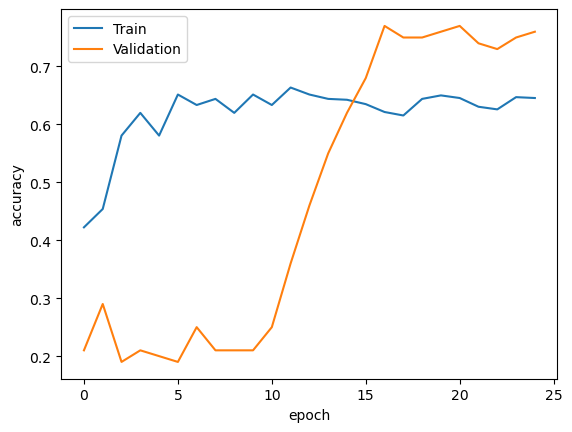

In [47]:
plt.plot(history6.history['categorical_accuracy'])
plt.plot(history6.history['val_categorical_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Validation'])

### Though the model looked promissing for the first 4 epochs, it didnt turn out to be fruitful.

### Experiment - 7
Lets try the same netwok as above by changing the optimizer from SGD to Adam
#### Model-7: 
- Optimizer : Adam
- Learning_rate : 0.001
- Epochs : 40
- Frames_per_vedio : 30
- batch_size : 35
- image_size : 140 x 140

In [50]:
gestures=5
learning_rate = 0.001
num_epochs = 40
gestures=5
frames_per_vedio = 30
batch_size = 35
x = 140
y = 140




#write your model here
#Layer-1
model7 = Sequential()
model7.add(Conv3D(8,(3,3,3),padding='same', input_shape = (frames_per_vedio, x, y, 3)))
model7.add(BatchNormalization())
model7.add(Activation('relu'))
model7.add(MaxPooling3D(pool_size=(2, 2, 2)))

#model.add(MaxPooling3D(pool_size = (2,2,2)))

model7.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
model7.add(BatchNormalization())
model7.add(Activation('relu'))
model7.add(MaxPooling3D(pool_size=(2, 2, 2)))

model7.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model7.add(BatchNormalization())
model7.add(Activation('relu'))
model7.add(MaxPooling3D(pool_size=(2, 2, 2)))


model7.add(Flatten())
model7.add(Dense(128, activation = 'relu'))
model7.add(BatchNormalization())
model7.add(Dropout(0.5))

model7.add(Dense(128, activation = 'relu'))
model7.add(BatchNormalization())
model7.add(Dropout(0.5))



model7.add(Dense(gestures, activation = 'softmax'))

optimiser = tf.keras.optimizers.Adam(learning_rate = 0.001)
#optimiser =  optimizers.SGD(learning_rate = 0.001, weight_decay  = 1e-5, momentum = 0.7, nesterov = True)#write your optimizer
model7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model7.summary())

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_57 (Conv3D)          (None, 30, 140, 140, 8)   656       
                                                                 
 batch_normalization_84 (Ba  (None, 30, 140, 140, 8)   32        
 tchNormalization)                                               
                                                                 
 activation_54 (Activation)  (None, 30, 140, 140, 8)   0         
                                                                 
 max_pooling3d_57 (MaxPooli  (None, 15, 70, 70, 8)     0         
 ng3D)                                                           
                                                                 
 conv3d_58 (Conv3D)          (None, 15, 70, 70, 32)    6944      
                                                                 
 batch_normalization_85 (Ba  (None, 15, 70, 70, 32)  

In [51]:
 history7 = model7.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/40
34/34 [==============================] - ETA: 0s - loss: 2.3518 - categorical_accuracy: 0.3077
Epoch 1: saving model to model_init_2024-01-0210_29_35.492045\model-00001-2.35176-0.30769-2.00116-0.17000.h5
34/34 [==============================] - 204s 6s/step - loss: 2.3518 - categorical_accuracy: 0.3077 - val_loss: 2.0012 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/40
34/34 [==============================] - ETA: 0s - loss: 1.7151 - categorical_accuracy: 0.4072
Epoch 2: saving model to model_init_2024-01-0210_29_35.492045\model-00002-1.71513-0.40724-1.95160-0.29000.h5
34/34 [==============================] - 193s 6s/step - loss: 1.7151 - categorical_accuracy: 0.4072 - val_loss: 1.9516 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 3/40
34/34 [==============================] - ETA: 0s - loss: 1.4177 - categorical_accuracy: 0.5143
Epoch 3: saving model to model_init_2024-01-0210_29_35.492045\model-00003-1.41767-0.51433-2.23830-0.25000.h5
34/34 [==============

34/34 [==============================] - ETA: 0s - loss: 0.8539 - categorical_accuracy: 0.6697
Epoch 21: saving model to model_init_2024-01-0210_29_35.492045\model-00021-0.85393-0.66968-0.73869-0.72000.h5
34/34 [==============================] - 188s 6s/step - loss: 0.8539 - categorical_accuracy: 0.6697 - val_loss: 0.7387 - val_categorical_accuracy: 0.7200 - lr: 1.0000e-08
Epoch 22/40
34/34 [==============================] - ETA: 0s - loss: 0.8805 - categorical_accuracy: 0.6863
Epoch 22: saving model to model_init_2024-01-0210_29_35.492045\model-00022-0.88054-0.68627-0.86484-0.72000.h5
34/34 [==============================] - 188s 6s/step - loss: 0.8805 - categorical_accuracy: 0.6863 - val_loss: 0.8648 - val_categorical_accuracy: 0.7200 - lr: 1.0000e-08
Epoch 23/40
34/34 [==============================] - ETA: 0s - loss: 0.8758 - categorical_accuracy: 0.6727
Epoch 23: saving model to model_init_2024-01-0210_29_35.492045\model-00023-0.87580-0.67270-0.80509-0.68000.h5

Epoch 23: ReduceLR

34/34 [==============================] - 190s 6s/step - loss: 0.9029 - categorical_accuracy: 0.6410 - val_loss: 0.9130 - val_categorical_accuracy: 0.7000 - lr: 1.0000e-15


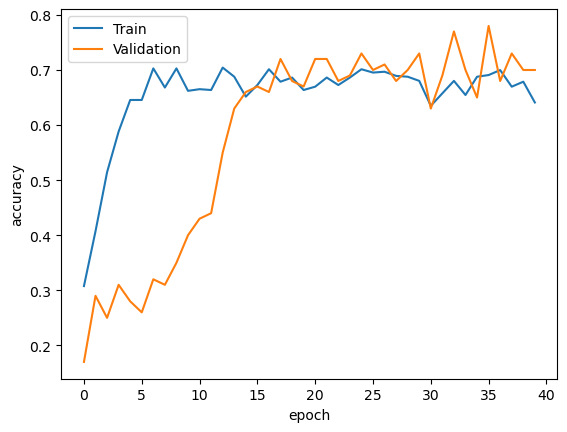

In [52]:
plt.plot(history7.history['categorical_accuracy'])
plt.plot(history7.history['val_categorical_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Validation'])

#### Though the accuracies are have reached almost same after 15th epoch, the magnitude of accuracy is excellent.

### Conclusion
### Best Model: 
### Model - 2 with train accuracy of 85 and validation accuracy 83, val_loss of 0.44. Model size = 9.62MB